# Recurrent Neural Networks

In this workshop, we will use RNNs to predict a time series:

For example, the daily exchange rates from SGD to USD.

https://data.gov.sg/dataset/exchange-rates-sgd-per-unit-of-usd-average-for-period-annual

1. Load data
2. Transform the sequence to a stationary sequence
3. Transform the sequence to a supervised learning dataset
3. Train Recurrent Neural Network using LSTM layers

Example: https://www.kaggle.com/niyamatalmass/machine-learning-for-time-series-analysis/notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM # if using CPU
# if using GPU, try this instead of LSTM (faster)
# from keras.layers import CuDNNLSTM

from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


## Load Data

In [2]:
# parse dates and set the date column as index
df = pd.read_csv('exchange-rates-sgd-per-unit-of-usd-daily.csv',
                 parse_dates=True, index_col=0)
df.head()

,exchange_rate_usd
date,
1988-01-08,2.0443
1988-01-15,2.0313
1988-01-22,2.0205
1988-01-29,2.0182
1988-02-05,2.0160


In [3]:
df.tail()

,exchange_rate_usd
date,
2015-10-13,1.4030
2015-10-14,1.3933
2015-10-15,1.3763
2015-10-16,1.3834
2015-10-19,1.3827


## Transform to Stationary

Non-stationary time series data is difficult to forecast because it relies on factors (features) that are independent of time

Reference: https://medium.com/@kangeugine/time-series-check-stationarity-1bee9085da05

Tests for stationarity: 
- https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [4]:
print(df.values[:5]) # original values

# convert to stationary by taking the first order difference
df.diff().head() # value[n] - value[n-1]

[[2.0443]
 [2.0313]
 [2.0205]
 [2.0182]
 [2.016 ]]


,exchange_rate_usd
date,
1988-01-08,NaN
1988-01-15,-0.0130
1988-01-22,-0.0108
1988-01-29,-0.0023
1988-02-05,-0.0022


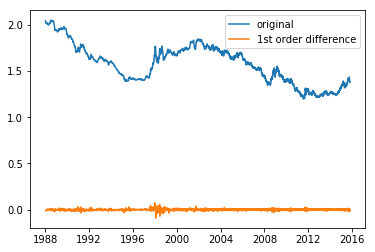

In [5]:
# plot the original and the difference
fig, ax = plt.subplots()
ax.plot(df, label='original')
ax.plot(df.diff(), label='1st order difference')
ax.legend()

## Transform to supervised learning

Example code that transforms a sequence into a supervised learning dataset

This example illustrates a single feature.

A more comprehensive example (with multiple features):
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [13]:
def sequence_to_supervised_learning(series, window_size):
    """Transforms a sequence into a supervised
    learning dataset
    
    Inputs:
        series - the input sequence
        window_size - the window sizes to create
    Output:
        a supervised learning dataset, of window size as features
        and the current value as the target
    """
    result = series.copy()
    for i in range(window_size):
        # shift the series forward by 1 step each time
        # then append the shifted series to the result
        result = pd.concat([result, series.shift(-(i+1))], axis=1)

    # last window_size rows will have missing values because
    # they are shifted into the future
    result.dropna(inplace=True)
    return result

In [12]:
window_size = 5
df_new = sequence_to_supervised_learning(pd.DataFrame(df.diff().values),
                                         window_size)
df_new.head()

,0,0,0,0,0,0
1,-0.0130,-0.0108,-0.0023,-0.0022,0.0013,0.0016
2,-0.0108,-0.0023,-0.0022,0.0013,0.0016,-0.0059
3,-0.0023,-0.0022,0.0013,0.0016,-0.0059,0.0024
4,-0.0022,0.0013,0.0016,-0.0059,0.0024,-0.0023
5,0.0013,0.0016,-0.0059,0.0024,-0.0023,0.0053


In [11]:
# Create X, y
X = df_new.iloc[:, :-1] # x[t-window] ... x[t-1]
y = df_new.iloc[:, -1] # y = x[t]
print(X.shape, y.shape)

(3987, 5) (3987,)


### Train/Test Split

For train_test_split:
* shuffle=False is common if we are using time series data. Note that it's strictly not needed for windowed because we already have history described in the features

If you are using sklearn to train (and not keras), and need to use cross_validation, consider TimeSeriesSplit: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [9]:
# train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [10]:
# scale using MinMaxScaler (common practice for RNN due to
# prevalence of tanh, which is -1, 1)
# MinMaxScaler(feature_range=(-1, 1))

# Actually, don't really need to scale because
# our inputs are already very small and within -1, 1 range
# this was doing redundant work.
# (But: check what your actual data range is.)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## Train model

- Architecture

```

# reshape:
#   from num_rows, num_features
#   to num_rows, sequence_length, num_features

X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

batch_size=1
sequence_length=X_train.shape[1]
num_features=X_train.shape[2]

model = Sequential()
model.add(LSTM(input_shape=(1, num_features),
   batch_input_shape=(batch_size, sequence_length, num_features),
   stateful=True, # saves state in between batches(!)
   units=sequence_length*2)) # tunable

model.add(Dense(1)) # output with no activation (regression)
```

- optimizer: try rmsprop or adam
- loss: mse
- metrics: mae

In [15]:
sequence_length = 1
num_features=window_size

X_train_rnn = X_train_sc.reshape(X_train_sc.shape[0],
                                 sequence_length,
                                 X_train_sc.shape[1])

batch_size=1

model = Sequential()
model.add(LSTM(input_shape=(sequence_length, num_features),
   batch_input_shape=(batch_size, sequence_length, num_features),
   stateful=True, # saves state in between batches(!)
   units=sequence_length*2)) # tunable

model.add(Dense(1)) # output with no activation (regression)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 2)                    64        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    3         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fitting RNNs is a bit tricker than CNN or Dense layers
# Have to look harder for good examples:
#
# https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

import time

es = EarlyStopping(patience=1, monitor='val_mean_absolute_error')
tb = TensorBoard(log_dir='./logs/rnn/{}'.format(int(time.time())))
mc = ModelCheckpoint('rnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5')

model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mae'])

# note: validation and training sizes need to be divisible
# by batch_size for training RNNs
model.fit(X_train_rnn, y_train, epochs=3, 
          batch_size=batch_size,
          callbacks=[es, tb, mc],
          shuffle=False,
          validation_split=.2)

Train on 2392 samples, validate on 598 samples
Epoch 1/3
2392/2392 [==============================] - 34s 14ms/step - loss: 2.8330e-04 - mean_absolute_error: 0.0091 - val_loss: 2.9769e-05 - val_mean_absolute_error: 0.0040
Epoch 2/3
2392/2392 [==============================] - 26s 11ms/step - loss: 8.8656e-05 - mean_absolute_error: 0.0057 - val_loss: 2.5668e-05 - val_mean_absolute_error: 0.0038
Epoch 3/3
2392/2392 [==============================] - 19s 8ms/step - loss: 7.9738e-05 - mean_absolute_error: 0.0055 - val_loss: 2.5489e-05 - val_mean_absolute_error: 0.0038


## Predictions

Typically, prediction is done in a loop, where the previous prediction
result is fed into the next input

However, this assumes that we are using window_size of 1

In [17]:
# one step forecast (predict one at a time)
pred = []

for i in range(len(X_test_sc)):
    X_t = X_test_sc[i]
    X_t = X_t.reshape(batch_size, sequence_length, X_t.shape[0])
    yhat = model.predict(X_t, batch_size=batch_size)
    print(yhat.flatten()[0])
    pred.append(yhat.flatten()[0])

2.3843138e-05
-0.0003706502
-0.00049133843
0.0010363696
-0.0005987553
0.0013112066
0.0010633109
0.0027020401
-0.0016618768
-0.0022925981
-0.0012007138
-0.00014804176
0.0010800374
-0.0018035868
-0.0017131591
-0.002161576
0.00020956376
-0.0001848588
-0.0010216931
-0.0008217903
0.00027586275
-0.00047329313
-0.00050179905
-0.00046202785
-0.00050781167
0.00019110308
0.0008357422
0.00049749145
0.0015135476
0.00042664015
0.0013675963
-7.723516e-05
0.000642178
0.00015308463
-0.00034700579
-0.00054176396
-0.0009185808
0.000113946735
-0.0013637604
-0.00036278612
-0.0003713282
9.563321e-05
0.00074007676
-0.00020965433
0.0013750953
4.2365282e-05
0.0003438344
-0.00037739298
-0.00021182245
0.00014349574
0.00025026628
0.0011037564
0.0005217282
-0.00080397597
-0.00017645082
-0.00055653846
0.00042774656
0.0003897933
-0.00017285964
0.0009545231
0.00017631741
0.001337062
0.0014297193
0.0009495703
0.0014000809
0.00078781263
0.0011427266
0.00070463994
1.6074046e-05
0.0008906567
-0.0002909141
0.0013501731
-

0.0002643218
0.00013184675
0.00055970007
-6.2386156e-05
-0.00056502095
-0.0007153662
-2.3181201e-05
0.000522585
0.0005579045
0.00031058246
0.0004721632
0.00054429227
0.00029862055
0.00023116672
-0.00020823127
0.00038897747
-6.9419504e-05
0.00081267336
0.0003767436
0.0010296641
0.0003166435
-0.000107275904
-0.00019439182
-7.253012e-05
0.00028719136
0.00022271776
-0.00030062965
-0.00020807853
-0.00025440624
0.00014909485
6.8140565e-05
6.736943e-05
0.00023042539
0.0003179101
0.00035149732
0.000521229
2.727413e-05
0.0004401555
-4.992506e-05
0.0001731118
-8.221215e-05
-0.00012611842
4.5006513e-05
5.575025e-05
-1.8993975e-05
0.00013184303
-0.000119986595
0.00023615861
-0.00014830253
-0.000102917315
-0.00011825061
3.0116527e-05
3.775349e-07
0.00013437995
-8.745736e-05
-3.3127726e-05
7.038505e-05
0.00027713308
0.0005672438
0.000347325
3.6754995e-05
0.00028352567
0.00017150247
0.00022781023
-0.00051607436
0.00014160702
-8.6932094e-05
0.0005839778
7.343793e-05
-1.5305937e-05
6.970519e-05
-3.5340

In [18]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, pred)

0.003223606416021091

In [20]:
# take the inverse difference to reconstruct y
# then plot

start_index = y_test.index[0] # start of test data
end_index = y_test.index[-1] # end of test data
training_end_index = start_index-1 # end of training data

# last value of training data
start_value = df.iloc[training_end_index]['exchange_rate_usd']

# compute the predictions using cumulative sum
df_reconstructed = pd.DataFrame({'predictions': [start_value] + pred}).cumsum()
df_reconstructed['truth'] = df.iloc[training_end_index:end_index+1].values
df_reconstructed.head()

,predictions,truth
0,1.265600,1.2656
1,1.265624,1.2672
2,1.265253,1.2642
3,1.264762,1.2701
4,1.265798,1.2808


In [16]:
df_reconstructed.tail()

,predictions,truth
993,0.312087,1.4237
994,0.311741,1.4243
995,0.312661,1.4140
996,0.313041,1.4018
997,0.311235,1.4020


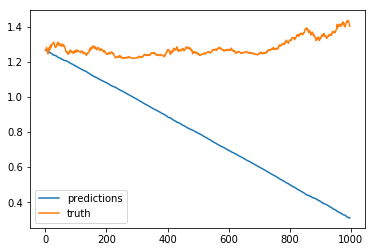

In [17]:
df_reconstructed.plot()

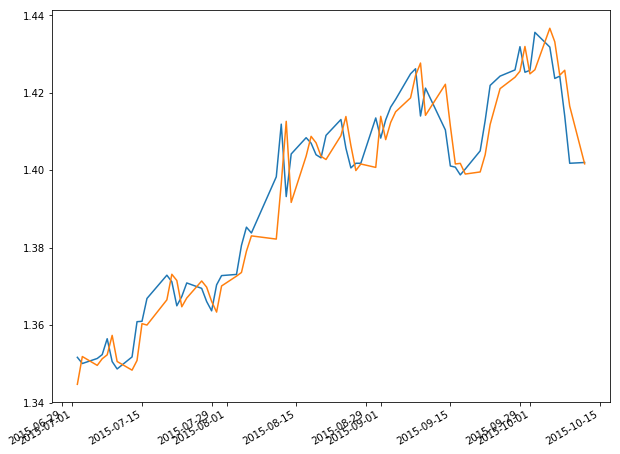

In [21]:
# Conclusion:
# RNN predicted a long term decreasing trend (which is obviously wrong)

# Let's try summing with the previous truth value
# This will minimize errors if you have access to that data
# (short term prediction strategy)

train_end_index = y_train.index[-1] # end of training data
start_index = y_test.index[0] # start of test data
end_index = y_test.index[-1] # end of test data
truth_price = df.iloc[train_end_index:end_index+1]
truth_price

# get the previous exchange rate so that we can predict
# the current one using this formula:
#   current = previous + pred_diff
df_short_term = truth_price.copy()
df_short_term['prev_exchange_rate'] = df_short_term.shift(1)
df_short_term.dropna(inplace=True)

df_short_term['pred_diff'] = pred
df_short_term['pred_price'] = df_short_term['prev_exchange_rate'] + pred

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_short_term.loc[df_short_term.index > '2015-07', 
                          ['exchange_rate_usd', 'pred_price']])

fig.autofmt_xdate()
#df_short_term.head()

In [19]:
# take the inverse difference to reconstruct y
# then plot


start_index = y_test.index[0] # start of test data
end_index = y_test.index[-1] # end of test data
training_end_index = start_index-1 # end of training data

# last value of training data
start_value = df.iloc[training_end_index]['exchange_rate_usd']

# compute the predictions using cumulative sum
df_reconstructed = pd.DataFrame({'predictions': [start_value] + pred}).cumsum()
df_reconstructed['truth'] = df.iloc[training_end_index:end_index+1].values

df_reconstructed.head()

,predictions,truth
0,1.265600,1.2656
1,1.266045,1.2672
2,1.264607,1.2642
3,1.262228,1.2701
4,1.261851,1.2808


In [20]:
# Plot training predictions
#
# take the inverse difference to reconstruct y
# then plot

start_index = y_train.index[0] # start of train data
end_index = y_train.index[-1] # end of train data

# first value of original data
start_value = df.iloc[0]['exchange_rate_usd']

# one step forecast (predict one at a time)
pred_train = []

for i in range(len(X_train_sc)):
    X_t = X_train_sc[i]
    X_t = X_t.reshape(batch_size, sequence_length, X_t.shape[0])
    yhat = model.predict(X_t, batch_size=batch_size)
    pred_train.append(yhat.flatten()[0])

# compute the predictions using cumulative sum
df_reconstructed = pd.DataFrame({'predictions': [start_value] + pred_train}).cumsum()
df_reconstructed['truth'] = df.iloc[0:end_index+1].values

df_reconstructed.head()

,predictions,truth
0,2.044300,2.0443
1,2.043691,2.0313
2,2.043734,2.0205
3,2.043828,2.0182
4,2.042710,2.0160


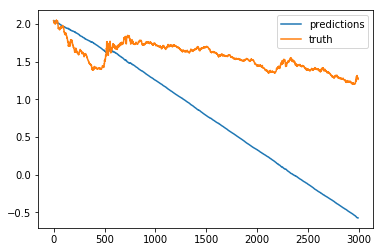

In [21]:
df_reconstructed.plot()